BRAIN CANCER CLASSIFICATION - RANDOM FOREST
Dataset: GSE50161

[1] Loading data...
               type  1007_s_at   1053_at     117_at    121_at  1255_g_at  \
samples                                                                    
834      ependymoma  12.498150  7.604868   6.880934  9.027128   4.176175   
835      ependymoma  13.067436  7.998090   7.209076  9.723322   4.826126   
836      ependymoma  13.068179  8.573674   8.647684  9.613002   4.396581   
837      ependymoma  12.456040  9.098977   6.628784  8.517677   4.154847   
838      ependymoma  12.699958  8.800721  11.556188  9.166309   4.165891   

          1294_at   1316_at   1320_at  1405_i_at  ...  AFFX-r2-Ec-bioD-3_at  \
samples                                           ...                         
834      7.224920  6.085942  6.835999   5.898355  ...              9.979005   
835      7.539381  6.250962  8.012549   5.453147  ...             11.924749   
836      7.813101  6.007746  7.178156   8.400266  ...             12

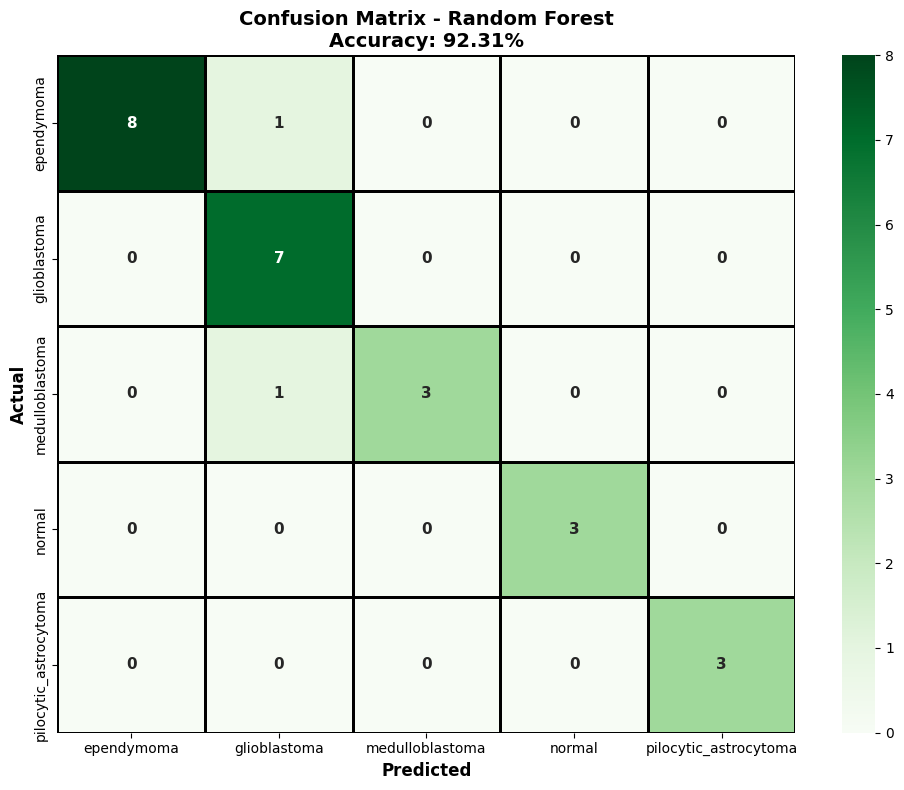


Per-Class Accuracy:
   ependymoma: 88.89% (8/9)
   glioblastoma: 100.00% (7/7)
   medulloblastoma: 75.00% (3/4)
   normal: 100.00% (3/3)
   pilocytic_astrocytoma: 100.00% (3/3)

[8] Creating ROC curves...


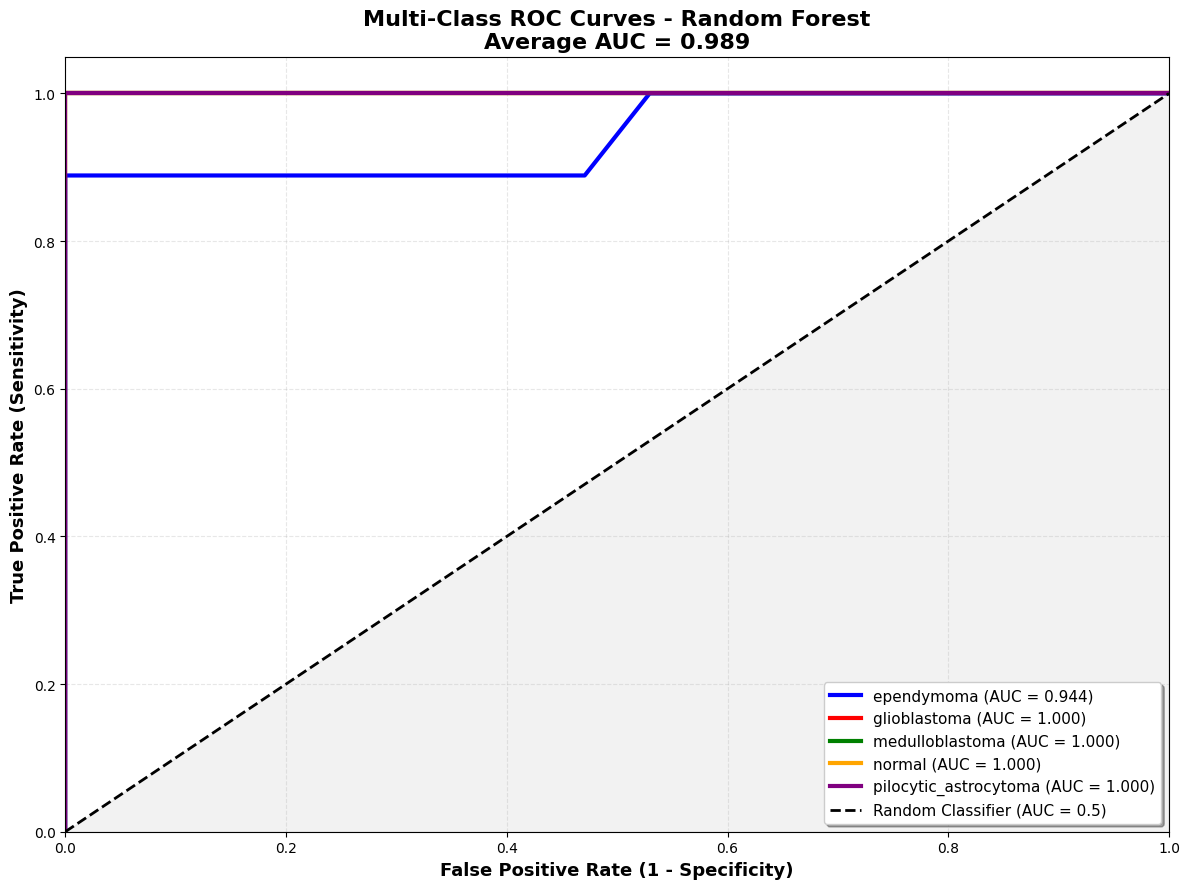


AUC SUMMARY
ependymoma                    : AUC = 0.9444
glioblastoma                  : AUC = 1.0000
medulloblastoma               : AUC = 1.0000
normal                        : AUC = 1.0000
pilocytic_astrocytoma         : AUC = 1.0000
------------------------------------------------------------
Average AUC                   : 0.9889

[9] Visualizing feature importance...


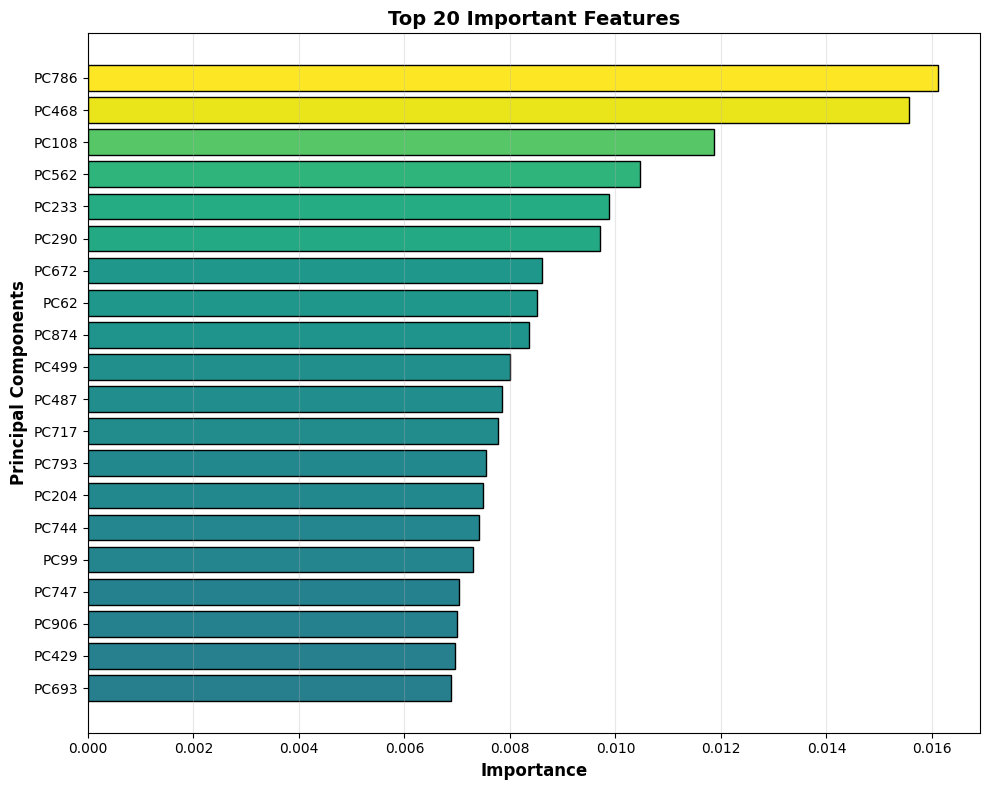


[10] Creating metrics summary visualization...


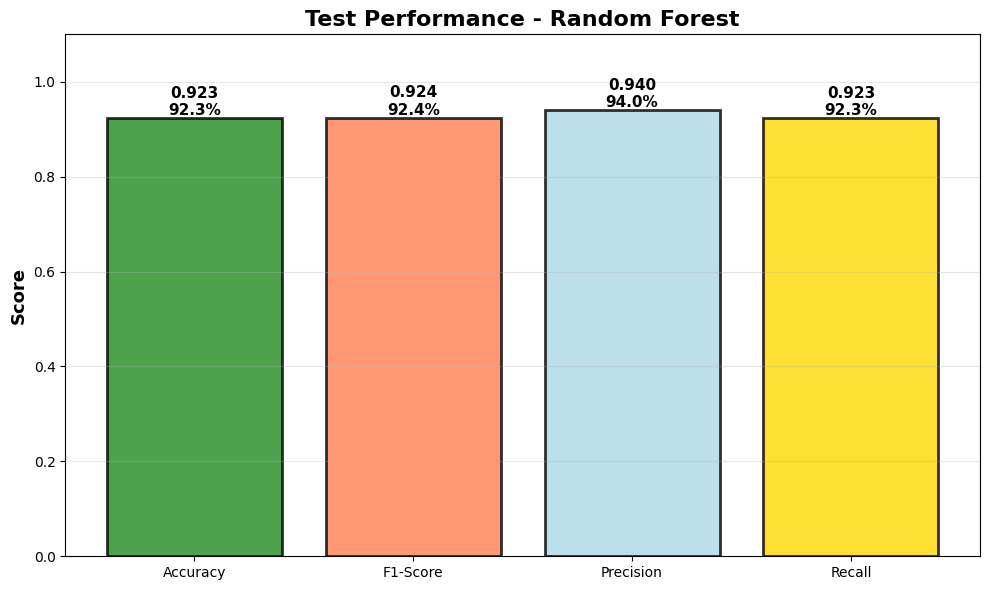

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, 
    f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

print("="*80)
print("BRAIN CANCER CLASSIFICATION - RANDOM FOREST")
print("Dataset: GSE50161")
print("="*80)

# Step 1: Load data and prepare features/target
print("\n[1] Loading data...")

df = pd.read_csv('Brain_GSE50161 2.csv', index_col=0)
print(df.head())

if 'type' in df.columns:
    y = df['type']
    X = df.drop(columns=['type'])
else:
    y = df.iloc[:, -1]
    X = df.iloc[:, :-1]

X = X.select_dtypes(include=[np.number])

print(f"Samples: {len(X)}")
print(f"Genes: {X.shape[1]}")

le = LabelEncoder()
y_encoded = le.fit_transform(y)
classes = le.classes_
n_classes = len(classes)

print(f"\nClasses: {classes}")
print(f"\nClass distribution:")
for cls in classes:
    count = sum(y == cls)
    print(f"   {cls}: {count} ({count/len(y)*100:.1f}%)")

# Step 2: Split data into training and test sets
print("\n[2] Splitting data into train and test sets...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"   Training samples: {len(X_train)}")
print(f"   Test samples: {len(X_test)}")

# Step 3: Feature selection with Random Forest
print("\n[3] Feature selection with Random Forest...")

rf_selector = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced',
    criterion='gini',
    n_jobs=-1
)

rf_selector.fit(X_train, y_train)

importances = rf_selector.feature_importances_
non_zero_importances = importances[importances > 0]

if len(non_zero_importances) > 0:
    median_threshold = np.median(non_zero_importances)
else:
    median_threshold = 0 

selected_features = X_train.columns[importances >= median_threshold]

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"   ✓ Selected {len(selected_features)} features out of {X_train.shape[1]}")

# Step 4: Standardize features
print("\n[4] Scaling features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

print("   ✓ Features standardized")

# Step 5: Hyperparameter tuning with GridSearchCV
print("\n[5] Training Random Forest with hyperparameter tuning...")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params, cv=cv, scoring='accuracy', n_jobs=-1, verbose=0
)

rf_grid.fit(X_train_scaled, y_train)
best_model = rf_grid.best_estimator_

print(f"\n   ✓ Best parameters: {rf_grid.best_params_}")
print(f"   ✓ Best CV Accuracy: {rf_grid.best_score_:.4f} ({rf_grid.best_score_*100:.2f}%)")

# Step 6: Make predictions and calculate metrics
print("\n[6] Making predictions on test set...")

y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)

test_acc = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, average='weighted')
test_prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
test_rec = recall_score(y_test, y_pred, average='weighted')

print("="*80)
print("TEST SET PERFORMANCE - RANDOM FOREST")
print("="*80)
print(f"\nAccuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"F1-Score:  {test_f1:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall:    {test_rec:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=classes, zero_division=0))

# Step 7: Create and visualize confusion matrix
print("\n[7] Creating confusion matrix...")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=classes, yticklabels=classes,
            annot_kws={'size': 11, 'fontweight': 'bold'},
            linewidths=2, linecolor='black')
plt.title(f'Confusion Matrix - Random Forest\nAccuracy: {test_acc*100:.2f}%', 
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nPer-Class Accuracy:")
for i, cls in enumerate(classes):
    if cm[i, :].sum() > 0:
        class_acc = cm[i, i] / cm[i, :].sum()
        print(f"   {cls}: {class_acc*100:.2f}% ({cm[i, i]}/{cm[i, :].sum()})")

# Step 8: Plot ROC curves for all classes
print("\n[8] Creating ROC curves...")

y_test_bin = label_binarize(y_test, classes=range(n_classes))

fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 9))
colors_roc = ['blue', 'red', 'green', 'orange', 'purple', 'brown']

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors_roc[i], lw=3,
             label=f'{classes[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=13, fontweight='bold')
plt.title(f'Multi-Class ROC Curves - Random Forest\nAverage AUC = {np.mean(list(roc_auc.values())):.3f}', 
          fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=11, frameon=True, shadow=True)
plt.grid(alpha=0.3, linestyle='--')
plt.fill_between([0, 1], [0, 1], [0, 0], alpha=0.1, color='gray', label='_nolegend_')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("AUC SUMMARY")
print("="*60)
for i, cls in enumerate(classes):
    print(f"{cls:30s}: AUC = {roc_auc[i]:.4f}")
print("-"*60)
print(f"{'Average AUC':30s}: {np.mean(list(roc_auc.values())):.4f}")
print("="*60)

# Step 9: Visualize feature importance
print("\n[9] Visualizing feature importance...")

importances = best_model.feature_importances_
top_20_idx = np.argsort(importances)[-20:]

plt.figure(figsize=(10, 8))
plt.barh(range(20), importances[top_20_idx], 
         color=plt.cm.viridis(importances[top_20_idx]/importances[top_20_idx].max()),
         edgecolor='black')
plt.yticks(range(20), [f'PC{i+1}' for i in top_20_idx])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Principal Components', fontsize=12, fontweight='bold')
plt.title('Top 20 Important Features', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Step 10: Visualize metrics summary
print("\n[10] Creating metrics summary visualization...")

plt.figure(figsize=(10, 6))
metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
values = [test_acc, test_f1, test_prec, test_rec]
colors_met = ['forestgreen', 'coral', 'lightblue', 'gold']

bars = plt.bar(metrics, values, color=colors_met, alpha=0.8, edgecolor='black', linewidth=2)

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., h, f'{h:.3f}\n{h*100:.1f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.ylabel('Score', fontsize=13, fontweight='bold')
plt.title('Test Performance - Random Forest', fontsize=16, fontweight='bold')
plt.ylim([0, 1.1])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
